In [1]:
import os, glob, json
import pandas as pd
import matplotlib.pyplot as plt

log_files = glob.glob("pilotTest/game_*agents_run*_*.json")


In [2]:
records = []
for path in log_files:
    data = json.load(open(path))
    meta = data["metadata"]
    # extract agent count and replicate from filename
    # e.g. "game_4agents_run1_20250801_103431.json"
    parts = os.path.basename(path).split("_")
    n_agents = int(parts[1].replace("agents",""))
    run_idx  = int(parts[2].replace("run",""))
    
    # Win flag
    werewolf_win = int(data["winner"] == "werewolves")
    
    # Days survived: if werewolf loses, find the day they were voted out;
    # otherwise take max day in events
    if werewolf_win:
        days_survived = max(evt["day"] for evt in data["events"] if "day" in evt)
    else:
        # find first elimination of the werewolf
        for evt in data["events"]:
            if evt["event_type"]=="elimination" and evt.get("target") in meta["roles"] \
               and meta["roles"][evt["target"]] == "werewolf":
                days_survived = evt["day"]
                break
        else:
            days_survived = 0

    # Count how many votes the werewolf received across all 'vote' events
    w_id = next(k for k,v in meta["roles"].items() if v=="werewolf")
    votes_received = 0
    for evt in data["events"]:
        if evt["event_type"]=="vote":
            # votes is a dict: voter→votee
            votes_received += sum(1 for votee in evt["votes"].values() if votee==w_id.replace("Agent","Agent"))
    records.append({
        "n_agents": n_agents,
        "run": run_idx,
        "werewolf_win": werewolf_win,
        "days_survived": days_survived,
        "votes_received": votes_received
    })

df = pd.DataFrame(records)
df.head()


,n_agents,run,werewolf_win,days_survived,votes_received
0,5,1,1,3,2
1,5,10,1,3,2
2,9,4,0,2,6
3,3,16,1,1,1
4,6,5,1,4,4


In [3]:
print(df)

     n_agents  run  werewolf_win  days_survived  votes_received
0           5    1             1              3               2
1           5   10             1              3               2
2           9    4             0              2               6
3           3   16             1              1               1
4           6    5             1              4               4
..        ...  ...           ...            ...             ...
104         6    9             1              3               2
105         9   11             1              6               1
106         9    7             1              5               2
107         8    4             0              2               6
108         4    5             1              2               2

[109 rows x 5 columns]


In [6]:
# Cell 3a — Baseline survival calculation
import numpy as np

def expected_survival(N: int) -> float:
    """
    Expected number of nights the werewolf survives under uniform random elimination:
      E = sum_{k=0..N-1} [∏_{i=0..k-1} (N-1-i)/(N-i)]
    We’ll normalize by (N-1) later.
    """
    return sum(
        np.prod([(N - 1 - i) / (N - i) for i in range(k)])
        for k in range(N)
    )


In [7]:
# Cell 3 — Compute per-condition summaries (including normalization & baselines)
summary = (
    df
    .groupby("n_agents")
    .agg(
        num_games       = ("werewolf_win",   "count"),
        win_rate        = ("werewolf_win",   "mean"),
        mean_survival   = ("days_survived",  "mean"),
        mean_votes_recv = ("votes_received", "mean")
    )
    .reset_index()
)

# --- add normalized proportions 0–1 ---
summary["survival_prop"] = summary["mean_survival"] / (summary["n_agents"] - 1)
summary["votes_prop"]    = summary["mean_votes_recv"] / (summary["n_agents"] - 1)

# --- add random-play baselines ---
summary["baseline_surv"]  = summary["n_agents"].apply(lambda N: expected_survival(N) / (N - 1))
summary["baseline_votes"] = 1.0 / summary["n_agents"]

summary


,n_agents,num_games,win_rate,mean_survival,mean_votes_recv,survival_prop,votes_prop,baseline_surv,baseline_votes
0,3,16,1.000000,1.000000,0.750000,0.500000,0.375000,1.000000,0.333333
1,4,16,1.000000,2.187500,1.375000,0.729167,0.458333,0.833333,0.250000
2,5,16,0.562500,2.437500,1.687500,0.609375,0.421875,0.750000,0.200000
3,6,15,0.666667,3.200000,2.266667,0.640000,0.453333,0.700000,0.166667
4,7,16,0.562500,2.875000,2.000000,0.479167,0.333333,0.666667,0.142857
5,8,16,0.312500,3.375000,3.875000,0.482143,0.553571,0.642857,0.125000
6,9,14,0.428571,3.928571,3.642857,0.491071,0.455357,0.625000,0.111111


### Plotting x-axis (# of agents) vs y-axis metrics

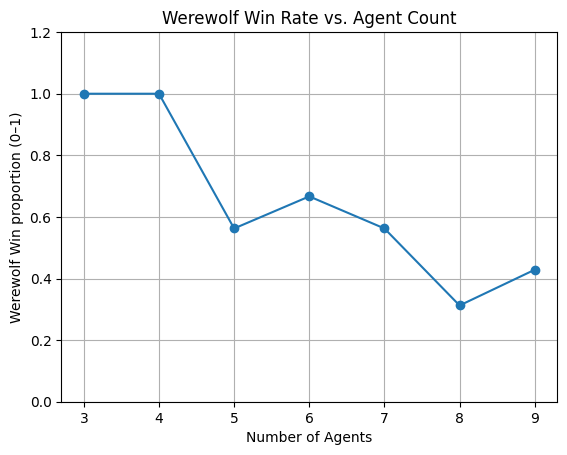

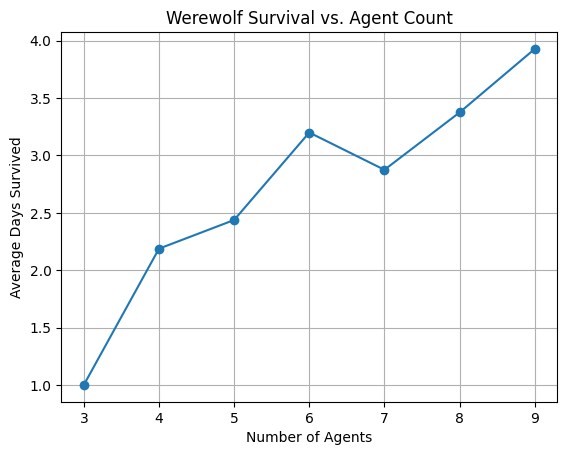

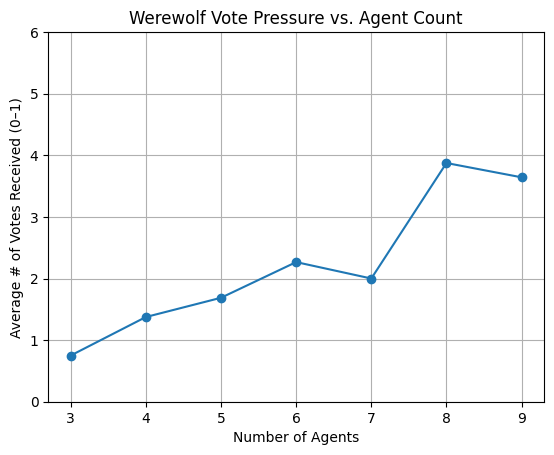

In [5]:
# 1) Win rate 
plt.figure()
plt.plot(summary["n_agents"], summary["win_rate"], marker='o')
plt.ylim(0, 1.2)
plt.xlabel("Number of Agents")
plt.ylabel("Werewolf Win proportion (0–1)")
plt.title("Werewolf Win Rate vs. Agent Count")
plt.grid(True)

# 2) Mean survival days
plt.figure()
plt.plot(summary["n_agents"], summary["mean_survival"], marker='o')
plt.xlabel("Number of Agents")
plt.ylabel("Average Days Survived")
plt.title("Werewolf Survival vs. Agent Count")
plt.grid(True)

# 3) Average votes received (treated as a proportion out of alive players, 0–1)
plt.figure()
plt.plot(summary["n_agents"], summary["mean_votes_recv"], marker='o')
plt.ylim(0, 6)
plt.xlabel("Number of Agents")
plt.ylabel("Average # of Votes Received (0–1)")
plt.title("Werewolf Vote Pressure vs. Agent Count")
plt.grid(True)

plt.show()


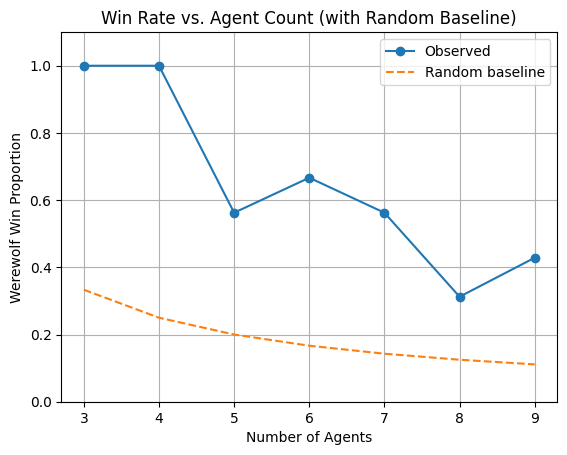

In [9]:
# Cell 4 — Win rate (already 0–1; add random baseline: chance of werewolf winning randomly)
plt.figure()
plt.plot(summary["n_agents"], summary["win_rate"], marker='o', label="Observed")
# Random-win baseline: under random voting/elimination the werewolf’s win-prob is 1/num_agents
plt.plot(summary["n_agents"], 1/summary["n_agents"], linestyle='--', label="Random baseline")
plt.ylim(0, 1.1)
plt.xlabel("Number of Agents")
plt.ylabel("Werewolf Win Proportion")
plt.title("Win Rate vs. Agent Count (with Random Baseline)")
plt.legend()
plt.grid(True)


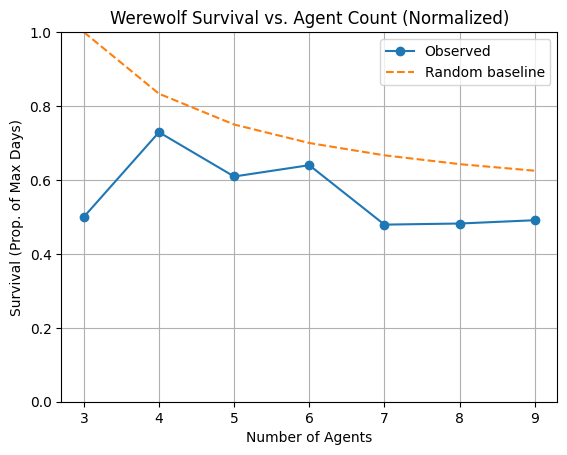

In [ ]:
# Cell 5 — Survival proportion vs. agent count
plt.figure()
plt.plot(summary["n_agents"], summary["survival_prop"],   marker='o', label="Observed")
plt.plot(summary["n_agents"], summary["baseline_surv"], linestyle='--', label="Random baseline")
plt.ylim(0, 1.1)
plt.xlabel("Number of Agents")
plt.ylabel("Survival (Prop. of Max Days)")
plt.title("Werewolf Survival vs. Agent Count (Normalized)")
plt.legend()
plt.grid(True)


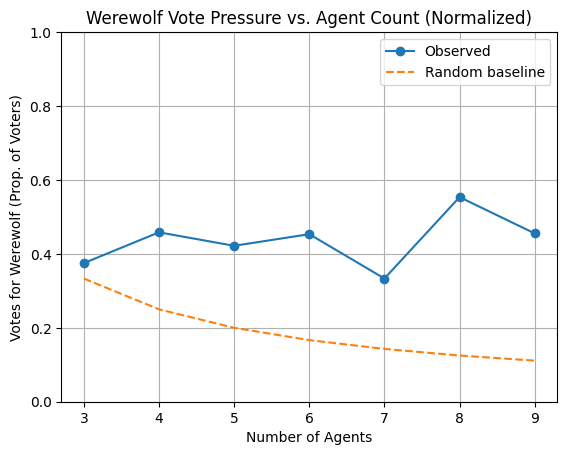

In [11]:
# Cell 6 — Vote pressure proportion vs. agent count
plt.figure()
plt.plot(summary["n_agents"], summary["votes_prop"],    marker='o', label="Observed")
plt.plot(summary["n_agents"], summary["baseline_votes"], linestyle='--', label="Random baseline")
plt.ylim(0, 1)
plt.xlabel("Number of Agents")
plt.ylabel("Votes for Werewolf (Prop. of Voters)")
plt.title("Werewolf Vote Pressure vs. Agent Count (Normalized)")
plt.legend()
plt.grid(True)


   n_agents  mean_influence  sem_influence  num_days
0         3        0.000000       0.000000        12
1         4        0.026316       0.026316        19
2         5        0.057471       0.027775        29
3         6        0.197917       0.049886        32
4         7        0.301515       0.060834        33
5         8        0.239216       0.064392        34
6         9        0.248906       0.056499        37


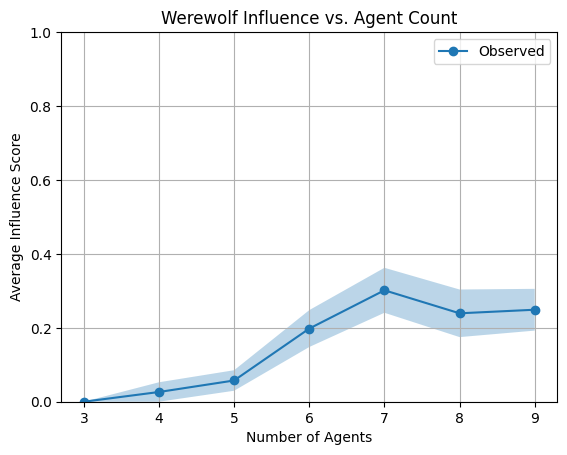

In [14]:
# Cell Z — Compute average “werewolf influence” per agent count
# Extract each day's votes, identify the werewolf's vote target, compute the fraction of other alive players
# who followed that vote. Hence the "influence" score. 


import glob
import json
import pandas as pd
import matplotlib.pyplot as plt

# 1) Parse all runs and compute per-day influence scores
records = []
for path in glob.glob("pilotTest/game_*agents_run*_*.json"):
    data = json.load(open(path))
    roles = data["metadata"]["roles"]
    # find the werewolf’s Agent ID, e.g. "Agent2"
    w_id = next(a for a, r in roles.items() if r == "werewolf")
    
    for evt in data["events"]:
        if evt.get("phase") == "day" and evt.get("event_type") == "vote":
            alive = evt.get("agents_alive", [])
            votes = evt.get("votes", {})
            # skip if werewolf didn't vote
            if votes.get(w_id, "NO VOTE") == "NO VOTE":
                continue
            
            target = votes[w_id]
            total_others = len(alive) - 1
            # count how many other players voted for that same target
            count_followers = sum(
                1 for voter, votee in votes.items()
                if voter != w_id and votee == target
            )
            influence = count_followers / total_others if total_others > 0 else 0
            
            records.append({
                "n_agents": data["metadata"]["num_agents"],
                "day": evt["day"],
                "influence": influence
            })

# 2) Build DataFrame and summarize by agent count
df_inf = pd.DataFrame(records)
summary_inf = (
    df_inf
    .groupby("n_agents")
    .agg(
        mean_influence=("influence", "mean"),
        sem_influence =("influence", "sem"),
        num_days       =("influence", "count")
    )
    .reset_index()
)
print(summary_inf)

# 3) Plot the mean influence score vs. number of agents
plt.figure()
plt.plot(summary_inf["n_agents"], summary_inf["mean_influence"], marker='o', label="Observed")
plt.fill_between(
    summary_inf["n_agents"],
    summary_inf["mean_influence"] - summary_inf["sem_influence"],
    summary_inf["mean_influence"] + summary_inf["sem_influence"],
    alpha=0.3
)
plt.ylim(0, 1)
plt.xlabel("Number of Agents")
plt.ylabel("Average Influence Score")
plt.title("Werewolf Influence vs. Agent Count")
plt.grid(True)
plt.legend()
plt.show()


   n_agents  mean_influence  sem_influence  num_days
0         3        0.000000       0.000000        12
1         4        0.000000       0.000000        22
2         5        0.175000       0.054712        20
3         6        0.160000       0.057317        25
4         7        0.222222       0.061747        18
5         8        0.327160       0.067897        27
6         9        0.288209       0.065754        21


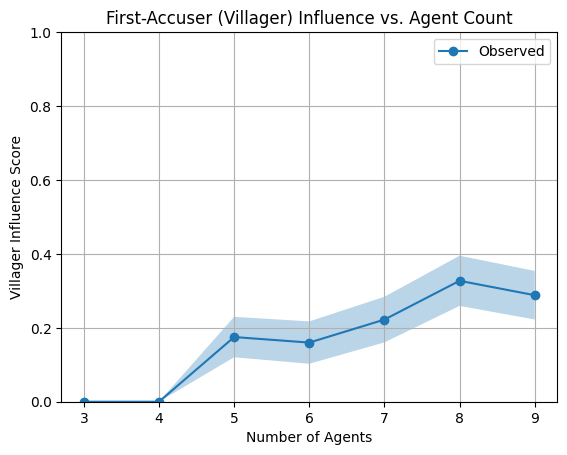

In [15]:
# Cell X — Compute average “villager influence” per agent count

import glob
import json
import pandas as pd
import matplotlib.pyplot as plt

# 1) Parse all runs and compute per-day villager influence scores
records_v = []
for path in glob.glob("pilotTest/game_*agents_run*_*.json"):
    data = json.load(open(path))
    roles = data["metadata"]["roles"]
    # identify werewolf’s Agent ID, e.g. "Agent2"
    w_id = next(agent for agent, role in roles.items() if role == "werewolf")
    
    for evt in data["events"]:
        if evt.get("phase") == "day" and evt.get("event_type") == "vote":
            alive = evt.get("agents_alive", [])
            votes = evt.get("votes", {})
            
            # Build an ordered list of votes if possible; otherwise use dict order
            vote_order = list(votes.items())
            
            # Find the first villager (non-werewolf) who votes for the werewolf
            first_accusers = [
                voter for voter, votee in vote_order
                if votee == w_id and roles.get(voter) == "villager"
            ]
            if not first_accusers:
                continue  # no villager accused this round
            
            first_accuser = first_accusers[0]
            total_others = len(alive) - 1  # exclude the first accuser
            # count how many other players also vote for the werewolf
            count_followers = sum(
                1 for voter, votee in vote_order
                if voter != first_accuser and votee == w_id
            )
            influence = count_followers / total_others if total_others > 0 else 0
            
            records_v.append({
                "n_agents": data["metadata"]["num_agents"],
                "day": evt["day"],
                "influence": influence
            })

# 2) Build DataFrame and summarize by agent count
df_vinf = pd.DataFrame(records_v)
summary_vinf = (
    df_vinf
    .groupby("n_agents")
    .agg(
        mean_influence=("influence", "mean"),
        sem_influence =("influence", "sem"),
        num_days       =("influence", "count")
    )
    .reset_index()
)
print(summary_vinf)

# 3) Plot the mean villager influence score vs. number of agents
plt.figure()
plt.plot(summary_vinf["n_agents"], summary_vinf["mean_influence"], marker='o', label="Observed")
plt.fill_between(
    summary_vinf["n_agents"],
    summary_vinf["mean_influence"] - summary_vinf["sem_influence"],
    summary_vinf["mean_influence"] + summary_vinf["sem_influence"],
    alpha=0.3
)
plt.ylim(0, 1)
plt.xlabel("Number of Agents")
plt.ylabel("Villager Influence Score")
plt.title("First-Accuser (Villager) Influence vs. Agent Count")
plt.grid(True)
plt.legend()
plt.show()
